<a href="https://colab.research.google.com/github/its-Ravi-Singh/Prac-NN-from-Scratch/blob/main/Pytorch_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1

In [176]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


### Introduction to PyTorch Tensors

In [177]:
print("torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

torch version: 2.9.0+cu126
device: cuda


In [178]:
# basic tensors
a = torch.tensor([3, 7, 11], dtype=torch.int64)
b = torch.tensor([1.5, 2.0, 3.25], dtype=torch.float32)

print(a, a.dtype)
print(b, b.dtype)

# creating tensors quickly for some standad forms
z = torch.zeros((2, 4))
o = torch.ones((3, 1))
r = torch.rand((2, 3))
n = torch.randn((2, 3))

print("zeros:\n", z)
print("ones:\n", o)
print("rand:\n", r)
print("randn:\n", n)

# reshape them + indexing
x = torch.arange(0, 20)
x2 = x.reshape(4, 5)
print("x2 :\n", x2)
print("row_0:", x2[0, :])
print("col_2:", x2[:, 2])

# broadcasting
col = torch.tensor([[1.0], [2.0], [3.0]])
row = torch.tensor([10.0, 20.0, 30.0])
print("broadcast:\n", col + row)

tensor([ 3,  7, 11]) torch.int64
tensor([1.5000, 2.0000, 3.2500]) torch.float32
zeros:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
ones:
 tensor([[1.],
        [1.],
        [1.]])
rand:
 tensor([[0.6027, 0.5853, 0.4259],
        [0.4521, 0.3170, 0.9850]])
randn:
 tensor([[ 0.1462,  1.3653, -1.3014],
        [-0.6202, -0.7868,  0.1177]])
x2 :
 tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
row_0: tensor([0, 1, 2, 3, 4])
col_2: tensor([ 2,  7, 12, 17])
broadcast:
 tensor([[11., 21., 31.],
        [12., 22., 32.],
        [13., 23., 33.]])


### The Fundamentals of Autograd

In [179]:
w = torch.tensor(2.0, requires_grad=True) # autograd demo
y = w*w + 3*w + 1
y.backward()

print("y =", y.item())
print("dy/dw =", w.grad.item())

y = 11.0
dy/dw = 7.0


### Building Models with PyTorch

In [180]:
class RegNetwork(nn.Module):
    def __init__(self):
      super().__init__()
      # input has 2 features, output is 16 neurons
      self.fc1 = nn.Linear(2, 16)
      # takes 16 inputs and gives single output
      self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
      x = self.fc1(x) # pass input through first layer
      x = torch.relu(x) # Apply Relu activation fn
      x = self.fc2(x) #pass through 2nd layer
      return x

model = RegNetwork().to(device)
print(model)

RegNetwork(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [181]:
# regression data
torch.manual_seed(7)

X = torch.randn(800, 2)
y_true = 2.5 * X[:, 0] - 1.2 * X[:, 1] + 0.3
y = y_true + 0.15 * torch.randn(800)


# split data
perm = torch.randperm(X.shape[0])

train_ids = perm[:600]
val_ids   = perm[600:700]
test_ids  = perm[700:]

X_train, y_train = X[train_ids].to(device), y[train_ids].to(device)
X_val, y_val     = X[val_ids].to(device),   y[val_ids].to(device)
X_test, y_test   = X[test_ids].to(device),  y[test_ids].to(device)

print("train:", X_train.shape, y_train.shape)
print("val  :", X_val.shape, y_val.shape)
print("test :", X_test.shape, y_test.shape)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# TensorBoard
writer = SummaryWriter("runs/a0_part1_tinyreg_student")

# Train loop (saving best model using val loss)
best_val_loss = float("inf")
best_model_path = "a0_part_1_weights_best.pt"

t0 = time.time()

num_epochs = 100
for epoch in range(num_epochs):
    # training
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train).squeeze()       # (600,)
    train_loss = criterion(y_pred, y_train)

    train_loss.backward()
    optimizer.step()

    # -validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val).squeeze()
        val_loss = criterion(val_pred, y_val)

    # log losses
    writer.add_scalar("loss/train", train_loss.item(), epoch + 1)
    writer.add_scalar("loss/val", val_loss.item(), epoch + 1)

    # save best
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        torch.save(model.state_dict(), best_model_path)

    # print sometimes
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:03d} | train loss: {train_loss.item():.4f} | val loss: {val_loss.item():.4f}")

print("training time (sec):", round(time.time() - t0, 2))

# 6) Test using best saved weights
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

with torch.no_grad():
    test_pred = model(X_test).squeeze()
    test_loss = criterion(test_pred, y_test)

print("best val loss:", round(best_val_loss, 4))
print("test loss:", round(test_loss.item(), 4))

writer.close()


train: torch.Size([600, 2]) torch.Size([600])
val  : torch.Size([100, 2]) torch.Size([100])
test : torch.Size([100, 2]) torch.Size([100])
Epoch 020 | train loss: 3.6597 | val loss: 4.3676
Epoch 040 | train loss: 0.3083 | val loss: 0.3031
Epoch 060 | train loss: 0.1219 | val loss: 0.1478
Epoch 080 | train loss: 0.0522 | val loss: 0.0598
Epoch 100 | train loss: 0.0413 | val loss: 0.0495
training time (sec): 0.23
best val loss: 0.0495
test loss: 0.0372


# Part 2

In [182]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

df = pd.read_csv(
    "Crime_Incidents_20260205.csv",
    engine="python",
    on_bad_lines="skip"   # skip broken rows
)


device: cuda


In [183]:
df = df.sample(n=60000, random_state=42).reset_index(drop=True)
print(df.shape)

(60000, 31)


In [184]:
df.columns

Index(['Case Number', 'Incident Datetime', 'Incident ID',
       'Incident Type Primary', 'Incident Description', 'Parent Incident Type',
       'Hour of Day', 'Day of Week', 'Address', 'City', 'State', 'Location',
       'Latitude', 'Longitude', 'Created At', 'updated_at', 'zip_code',
       'neighborhood', 'Council District', 'Council District 2011',
       'Census Tract', 'Census Block Group', 'Census Block',
       '2010 Census Tract ', '2010 Census Block Group', '2010 Census Block',
       'Police District', 'TRACTCE20', 'GEOID20_tract', 'GEOID20_blockgroup',
       'GEOID20_block'],
      dtype='object')

In [185]:
display(df.head())

,Case Number,Incident Datetime,Incident ID,Incident Type Primary,Incident Description,Parent Incident Type,Hour of Day,Day of Week,Address,City,...,Census Block Group,Census Block,2010 Census Tract,2010 Census Block Group,2010 Census Block,Police District,TRACTCE20,GEOID20_tract,GEOID20_blockgroup,GEOID20_block
0,14-1420856,2014 Apr 25 07:59:00 PM,NaN,LARCENY/THEFT,Buffalo Police are investigating this report o...,Theft,19,Friday,1 Block FRANKFORT AV,Buffalo,...,2,2002,35,3,3004,District C,003501,36029003501,360290001102,360290035022002
1,15-1650606,2015 Jun 14 01:35:00 PM,NaN,ASSAULT,Buffalo Police are investigating this report o...,Assault,13,Sunday,1 Block GOOD AV,Buffalo,...,4,4002,2,4,4002,District A,000200,36029000200,360290002004,360290002004002
2,13-3460402,2013 Dec 12 01:27:00 PM,NaN,ASSAULT,Buffalo Police are investigating this report o...,Assault,13,Thursday,400 Block KENSINGTON AV,Buffalo,...,1,1011,40.01,4,4011,District E,004002,36029004002,360290001101,360290035011011
3,09-2171072,2009 Aug 05 11:00:00 PM,NaN,ASSAULT,Buffalo Police are investigating this report o...,Assault,23,Wednesday,2300 Block DELAWARE AV,Buffalo,...,3,3006,56,3,3008,District D,005600,36029005600,360290001103,360290163003006
4,11-1560498,2011 Jun 04 05:00:00 AM,NaN,LARCENY/THEFT,Buffalo Police are investigating this report o...,Theft,5,Saturday,1 Block PARK ST,Buffalo,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN


In [186]:
print("\ndtypes")
print(df.dtypes)

print("\nmissing values")
missing = df.isna().sum().sort_values(ascending=False)
print(missing.head(15))

print("\nnumeric describe")
num_cols_all = df.select_dtypes(include=[np.number]).columns
display(df[num_cols_all].describe().T)


dtypes
Case Number                 object
Incident Datetime           object
Incident ID                float64
Incident Type Primary       object
Incident Description        object
Parent Incident Type        object
Hour of Day                  int64
Day of Week                 object
Address                     object
City                        object
State                       object
Location                    object
Latitude                    object
Longitude                   object
Created At                  object
updated_at                 float64
zip_code                    object
neighborhood                object
Council District            object
Council District 2011       object
Census Tract                object
Census Block Group          object
Census Block                object
2010 Census Tract           object
2010 Census Block Group     object
2010 Census Block           object
Police District             object
TRACTCE20                   object
GEOID20_trac

,count,mean,std,min,25%,50%,75%,max
Incident ID,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hour of Day,60000.0,11.978217,7.140518,0.0,7.0,13.0,18.0,23.0
updated_at,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
violent_types = ["ASSAULT", "ROBBERY", "HOMICIDE"]

df["violent"] = df["Incident Type Primary"].isin(violent_types).astype(int)
print("\nviolent label counts:")
print(df["violent"].value_counts())


violent label counts:
violent
0    44524
1    15476
Name: count, dtype: int64


In [188]:
df.columns

Index(['Case Number', 'Incident Datetime', 'Incident ID',
       'Incident Type Primary', 'Incident Description', 'Parent Incident Type',
       'Hour of Day', 'Day of Week', 'Address', 'City', 'State', 'Location',
       'Latitude', 'Longitude', 'Created At', 'updated_at', 'zip_code',
       'neighborhood', 'Council District', 'Council District 2011',
       'Census Tract', 'Census Block Group', 'Census Block',
       '2010 Census Tract ', '2010 Census Block Group', '2010 Census Block',
       'Police District', 'TRACTCE20', 'GEOID20_tract', 'GEOID20_blockgroup',
       'GEOID20_block', 'violent'],
      dtype='object')

In [189]:
df["Incident Datetime"] = pd.to_datetime(df["Incident Datetime"], errors="coerce")

df["year"] = df["Incident Datetime"].dt.year
df["month"] = df["Incident Datetime"].dt.month

df = df.drop(columns=["Incident Datetime"])

/tmp/ipython-input-1958190654.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Incident Datetime"] = pd.to_datetime(df["Incident Datetime"], errors="coerce")


In [190]:
df.columns

Index(['Case Number', 'Incident ID', 'Incident Type Primary',
       'Incident Description', 'Parent Incident Type', 'Hour of Day',
       'Day of Week', 'Address', 'City', 'State', 'Location', 'Latitude',
       'Longitude', 'Created At', 'updated_at', 'zip_code', 'neighborhood',
       'Council District', 'Council District 2011', 'Census Tract',
       'Census Block Group', 'Census Block', '2010 Census Tract ',
       '2010 Census Block Group', '2010 Census Block', 'Police District',
       'TRACTCE20', 'GEOID20_tract', 'GEOID20_blockgroup', 'GEOID20_block',
       'violent', 'year', 'month'],
      dtype='object')

In [191]:
drop_cols = [
    "Case Number",
    "Incident ID",
    "Address",
    "Location",
    "Created At",
    "updated_at",
]

In [192]:
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

print("\nshape after dropping columns:", df.shape)


shape after dropping columns: (60000, 27)


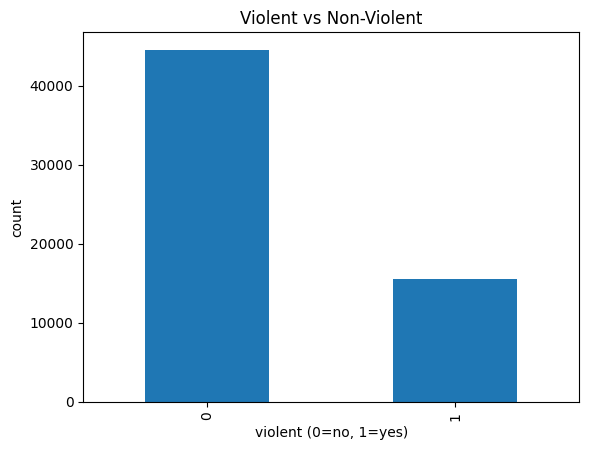

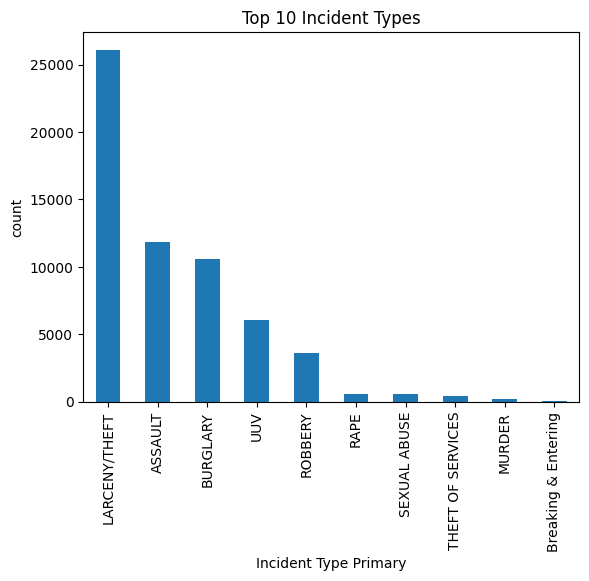

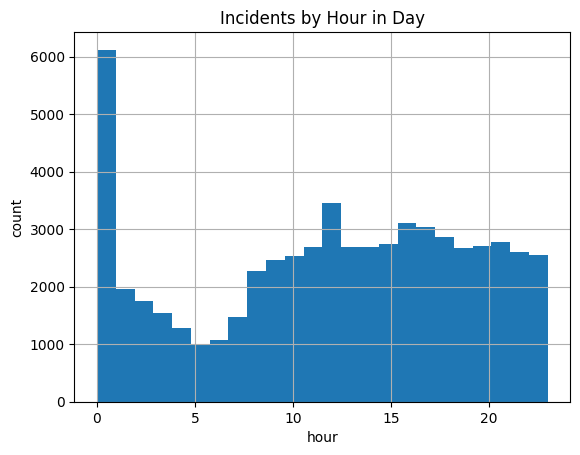

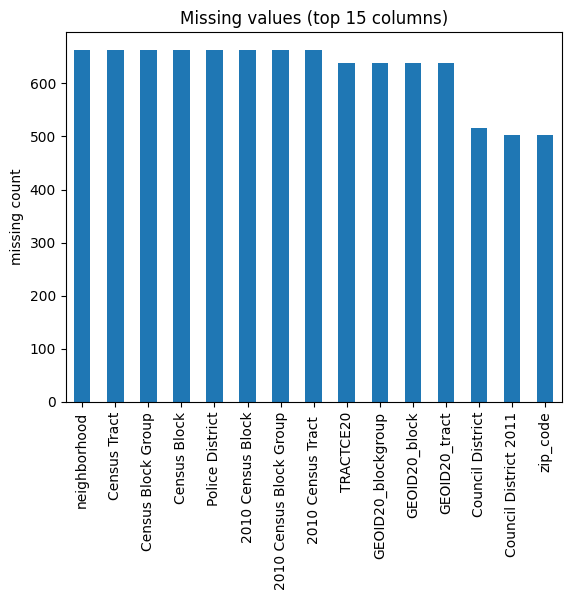

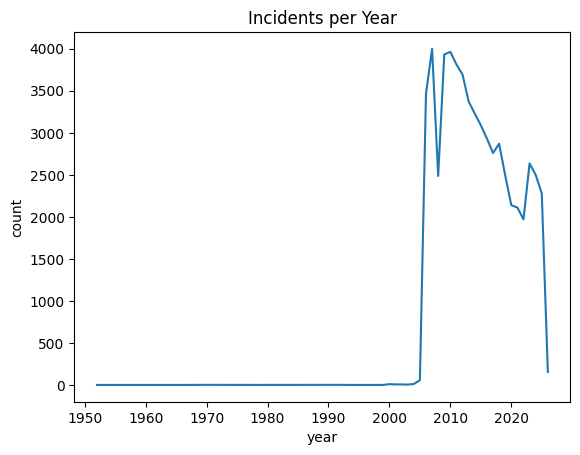

In [193]:
plt.figure()
df["violent"].value_counts().plot(kind="bar")
plt.title("Violent vs Non-Violent")
plt.xlabel("violent (0=no, 1=yes)")
plt.ylabel("count")
plt.show()

plt.figure()
df["Incident Type Primary"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Incident Types")
plt.ylabel("count")
plt.show()

plt.figure()
df["Hour of Day"].dropna().hist(bins=24)
plt.title("Incidents by Hour in Day")
plt.xlabel("hour")
plt.ylabel("count")
plt.show()

plt.figure()
df.isna().sum().sort_values(ascending=False).head(15).plot(kind="bar")
plt.title("Missing values (top 15 columns)")
plt.ylabel("missing count")
plt.show()

plt.figure()
df["year"].value_counts().sort_index().plot()
plt.title("Incidents per Year")
plt.xlabel("year")
plt.ylabel("count")
plt.show()

In [194]:
leak_cols = ["Incident Type Primary", "Incident Description", "Parent Incident Type"]

for c in leak_cols:
    if c in df.columns:
        df = df.drop(columns=[c])

print("Columns after leakage removal:")
print(df.columns)

Columns after leakage removal:
Index(['Hour of Day', 'Day of Week', 'City', 'State', 'Latitude', 'Longitude',
       'zip_code', 'neighborhood', 'Council District', 'Council District 2011',
       'Census Tract', 'Census Block Group', 'Census Block',
       '2010 Census Tract ', '2010 Census Block Group', '2010 Census Block',
       'Police District', 'TRACTCE20', 'GEOID20_tract', 'GEOID20_blockgroup',
       'GEOID20_block', 'violent', 'year', 'month'],
      dtype='object')


### Spliting Dataset

In [195]:
X = df.drop(columns=["violent"])
y = df["violent"]

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=seed, stratify=y_tmp
)

print("train:", X_train.shape, y_train.shape)
print("val  :", X_val.shape, y_val.shape)
print("test :", X_test.shape, y_test.shape)


train: (48000, 23) (48000,)
val  : (6000, 23) (6000,)
test : (6000, 23) (6000,)


### Preprocessing pipeline

In [196]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())  # scales to [0,1]
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


In [197]:
ml_models = {
    "LogisticRegression": LogisticRegression(max_iter=300),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=seed),
    "KNN": KNeighborsClassifier(n_neighbors=15),
}

ml_results = {}

for name, clf in ml_models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])

    t0 = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - t0

    val_pred = pipe.predict(X_val)
    test_pred = pipe.predict(X_test)

    val_acc = accuracy_score(y_val, val_pred)
    test_acc = accuracy_score(y_test, test_pred)

    ml_results[name] = {"val_acc": val_acc, "test_acc": test_acc, "train_time_sec": train_time}
    print(f"{name:18s} | val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | time={train_time:.2f}s")

print("\nML results:", ml_results)

LogisticRegression | val_acc=0.7363 | test_acc=0.7380 | time=2.39s
RandomForest       | val_acc=0.7198 | test_acc=0.7217 | time=355.07s
KNN                | val_acc=0.7263 | test_acc=0.7302 | time=0.32s

ML results: {'LogisticRegression': {'val_acc': 0.7363333333333333, 'test_acc': 0.738, 'train_time_sec': 2.3893630504608154}, 'RandomForest': {'val_acc': 0.7198333333333333, 'test_acc': 0.7216666666666667, 'train_time_sec': 355.06696128845215}, 'KNN': {'val_acc': 0.7263333333333334, 'test_acc': 0.7301666666666666, 'train_time_sec': 0.315859317779541}}


In [198]:
X_train_np = preprocess.fit_transform(X_train)
X_val_np   = preprocess.transform(X_val)
X_test_np  = preprocess.transform(X_test)

# OneHotEncoder
if hasattr(X_train_np, "toarray"):
    X_train_np = X_train_np.toarray()
    X_val_np   = X_val_np.toarray()
    X_test_np  = X_test_np.toarray()

y_train_np = y_train.to_numpy().astype(np.int64)
y_val_np   = y_val.to_numpy().astype(np.int64)
y_test_np  = y_test.to_numpy().astype(np.int64)

input_dim = X_train_np.shape[1]
print("NN input_dim:", input_dim)

NN input_dim: 3783


In [199]:
class TabDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


batch_size = 256
train_loader = DataLoader(TabDataset(X_train_np, y_train_np), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TabDataset(X_val_np, y_val_np), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TabDataset(X_test_np, y_test_np), batch_size=batch_size, shuffle=False)

In [206]:
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)   # 2 classes: 0/1
        )

    def forward(self, x):
        return self.net(x)


model = MLP(input_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)


def eval_model(model, loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)

            total_loss += loss.item() * len(xb)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_n += len(xb)

    return total_correct / total_n, total_loss / total_n

MLP(
  (net): Sequential(
    (0): Linear(in_features=3783, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [201]:
best_val_acc = -1.0
best_path = "a0_part_2_weights_50668604.pt"

history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

epochs = 20
t0 = time.time()

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_n = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(xb)
        running_correct += (logits.argmax(dim=1) == yb).sum().item()
        running_n += len(xb)

    train_acc = running_correct / running_n
    train_loss = running_loss / running_n

    val_acc, val_loss = eval_model(model, val_loader)

    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

    if epoch % 5 == 0 or epoch == 1:
        print(f"epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} "
              f"| train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

print("NN training time (sec):", round(time.time() - t0, 2))
print("best val acc:", round(best_val_acc, 4))

epoch 01 | train_acc=0.7406 val_acc=0.7422 | train_loss=0.5649 val_loss=0.5556
epoch 05 | train_acc=0.7432 val_acc=0.7433 | train_loss=0.5329 val_loss=0.5527
epoch 10 | train_acc=0.7502 val_acc=0.7363 | train_loss=0.5095 val_loss=0.5606
epoch 15 | train_acc=0.7629 val_acc=0.7265 | train_loss=0.4842 val_loss=0.5761
epoch 20 | train_acc=0.7776 val_acc=0.7255 | train_loss=0.4591 val_loss=0.5959
NN training time (sec): 21.32
best val acc: 0.7433


### Test NN using best weights

In [202]:
model.load_state_dict(torch.load(best_path, map_location=device))
test_acc, test_loss = eval_model(model, test_loader)
print("NN test_acc:", round(test_acc, 4), "test_loss:", round(test_loss, 4))

NN test_acc: 0.743 test_loss: 0.553


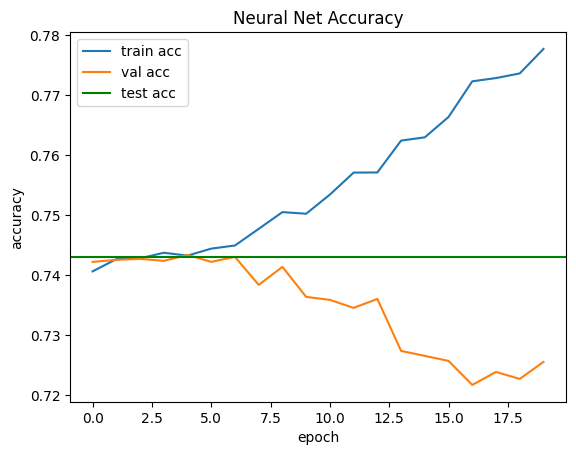

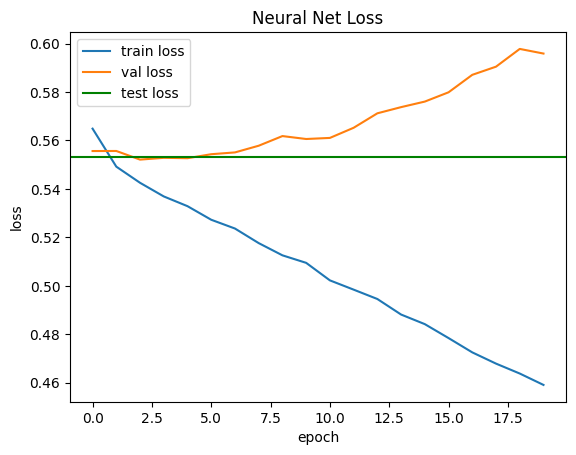

In [203]:
plt.figure()
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.axhline(test_acc, label="test acc", color='green')
plt.title("Neural Net Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.axhline(test_loss, label="test loss", color='green')
plt.title("Neural Net Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

### Confusion matrix + report for NN

In [204]:
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

cm = confusion_matrix(all_true, all_preds)
print("\nConfusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(all_true, all_preds))


Confusion matrix:
 [[4445    8]
 [1534   13]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      4453
           1       0.62      0.01      0.02      1547

    accuracy                           0.74      6000
   macro avg       0.68      0.50      0.43      6000
weighted avg       0.71      0.74      0.64      6000



In [205]:
print("Comparison")
for k, v in ml_results.items():
    print(f"{k:18s} | val_acc={v['val_acc']:.4f} | test_acc={v['test_acc']:.4f} | time={v['train_time_sec']:.2f}s")

print(f"{'NeuralNet':18s} | val_acc(best)={best_val_acc:.4f} | test_acc={test_acc:.4f}")


Comparison
LogisticRegression | val_acc=0.7363 | test_acc=0.7380 | time=2.39s
RandomForest       | val_acc=0.7198 | test_acc=0.7217 | time=355.07s
KNN                | val_acc=0.7263 | test_acc=0.7302 | time=0.32s
NeuralNet          | val_acc(best)=0.7433 | test_acc=0.7430
